In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import reading
import scipy.stats as st
import math
import yaml
import os
import numpy.lib.recfunctions as rfn
import scipy.signal as sg

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.backends.backend_pdf import PdfPages

Read antpos from default source


In [2]:

def simple_direction_fit(anntenna_summary_array,plot=True,toa_func=toa_plane,fitbounds=([0,0],[90,360])):
    #to run the direction fit code,I need arrays of x,y,z, t which are all with respect to a reference antenna
    #I will use the first non-flagged antenna as the reference
    x=anntenna_summary_array['x'] - anntenna_summary_array['x'][0]
    y=anntenna_summary_array['y'] - anntenna_summary_array['y'][0]
    z=anntenna_summary_array['z'] - anntenna_summary_array['z'][0]
    t=anntenna_summary_array['tpeak_rel'] - anntenna_summary_array['tpeak_rel'][0]
    print('Reference antenna',anntenna_summary_array['antname'][0])

    ant_coords=np.zeros((3,len(x)))
    ant_coords[0,:]=x
    ant_coords[1,:]=y
    ant_coords[2,:]=z

    popt, pcov = curve_fit(toa_func, ant_coords,t,bounds=fitbounds)
    best_model_toas=toa_func(ant_coords,*popt)
    residual=t-best_model_toas
    
    if plot:
        #plot the results
        czoom_min=-50
        czoom_max=50
        title='Fit with '+str(toa_func)[10:-19]
        plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)
    return(popt,pcov,residual)

def robust_direction_fit(antenna_summary_array,niter,outlier_limit,toa_func=toa_plane,fitbounds=([0,0],[90,360]),plot=True):
    current_ant_summary_array=antenna_summary_array
    for n in range(niter):
        popt,pcov,residual=simple_direction_fit(current_ant_summary_array,plot,toa_func,fitbounds)
        rms_residual=np.sqrt(np.mean(np.square(residual)))
        #calculate outliers
        antpols=np.asarray([current_ant_summary_array['antname'][i]+current_ant_summary_array['pol'][i] for i in range(len(residual))])
        residual_med=np.median(residual)
        abs_dev_from_med=np.abs(residual-residual_med)
        residual_MAD=np.median(abs_dev_from_med)
        outliers=antpols[abs_dev_from_med>outlier_limit*residual_MAD]

        current_ant_summary_array=flag_antennas(current_ant_summary_array,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                    configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],10,outliers)[0]
        if plot==True:
            #print details
            print('iteration: ',n,' rms residual: ',rms_residual, ' n outliers: ',len(outliers))
            print('popt: ',popt)
            print('pcov: ',pcov)
        return popt,pcov

def toa_sphere(ant_coords,theta,phi,r):
    #This calculates the arrival times at each antenna of a spherical wave moving across the array
    #The TOAs are returned in number of clock cycles relative to the arrival time at the origin
    #It is convenient to pick a reference antenna to define the origin and then work with antenna coordinates and arrival times with respect to that antenna
    #theta and phi in degrees
    #r and antenna coordinates in meters
    #theta is the angle between the source direction and zenith. Theta=0 for a zenith source
    #phi is the azimuth angle of the source
    
    c=3e8 #meters per second
    sample_rate=1.96e8 #MHz
    phi_rad=(phi*math.pi/180)
    theta_rad=theta*math.pi/180
    x,y,z=ant_coords
    
    #convert source position to cartesian coordinates 
    ys=r*math.sin(theta_rad)*math.cos(phi_rad)
    xs=r*math.sin(theta_rad)*math.sin(phi_rad)
    zs=r*math.cos(theta_rad)
    
    #distance from source to antenna
    d=np.sqrt(((x-xs)**2)+((y-ys)**2)+((z-zs)**2))
    
    #arrival time at antenna
    t=(1/c)*(d-r)
    
    #convert time to a number of clock cycles offset from the arrival time at the origin
    time_diff=t*sample_rate
    return time_diff

# Plot the event
Note that in the flagging step I'm flagging antennas that have any saturated samples, since those may mess up the Gaussian fit.

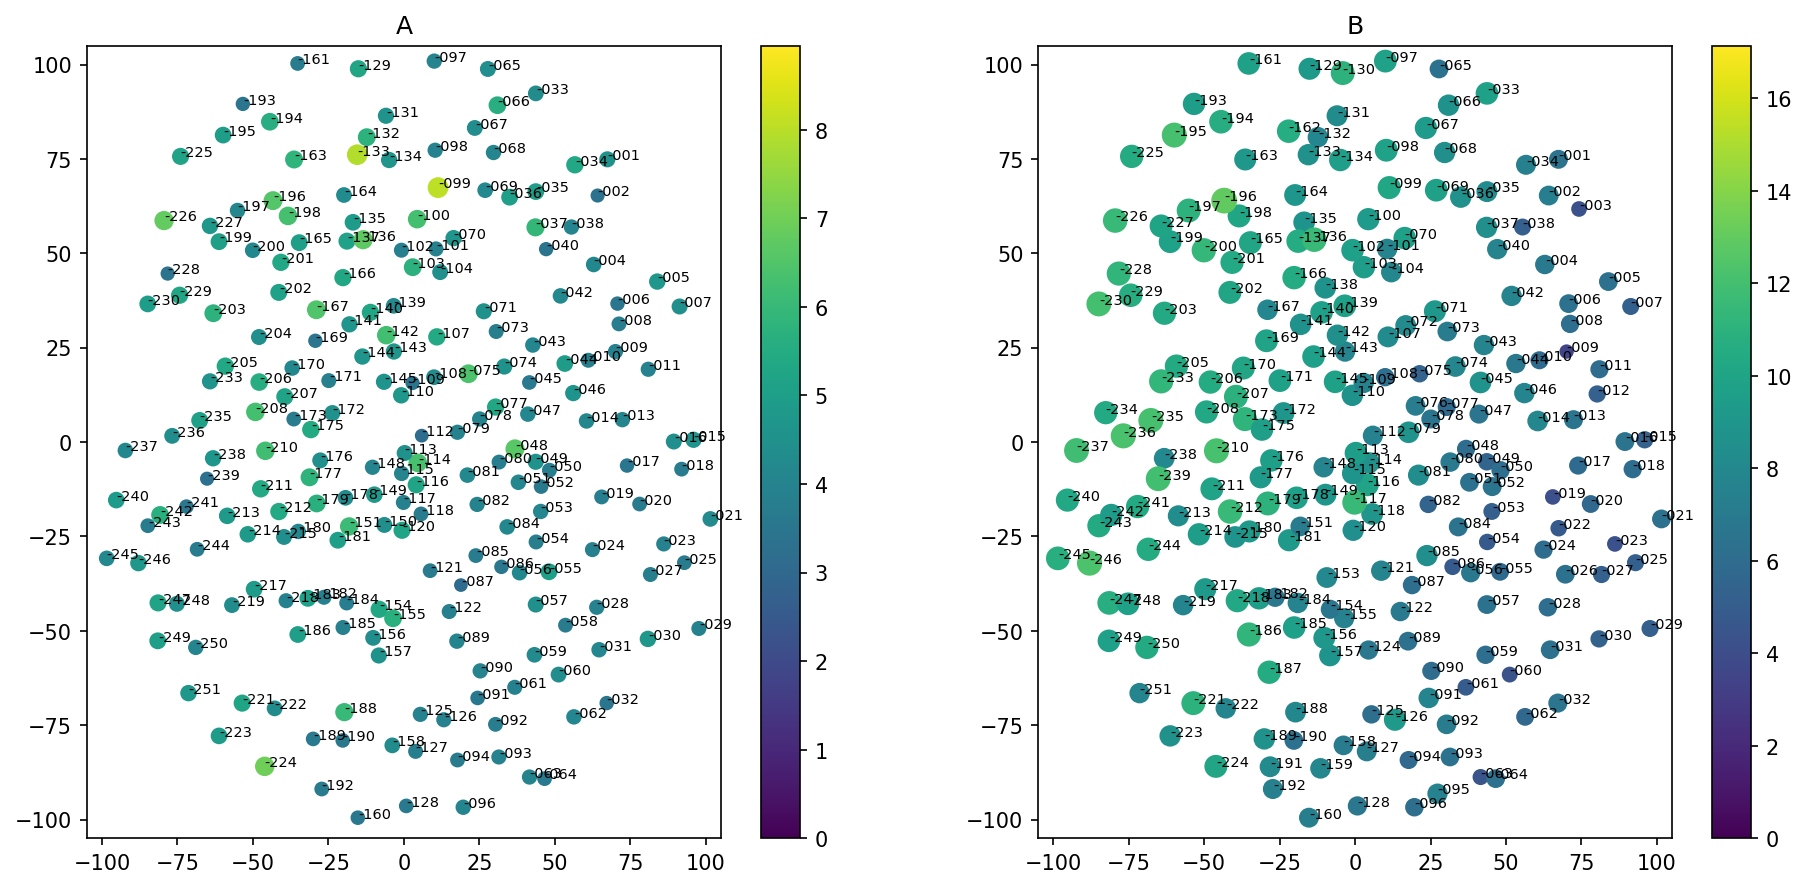

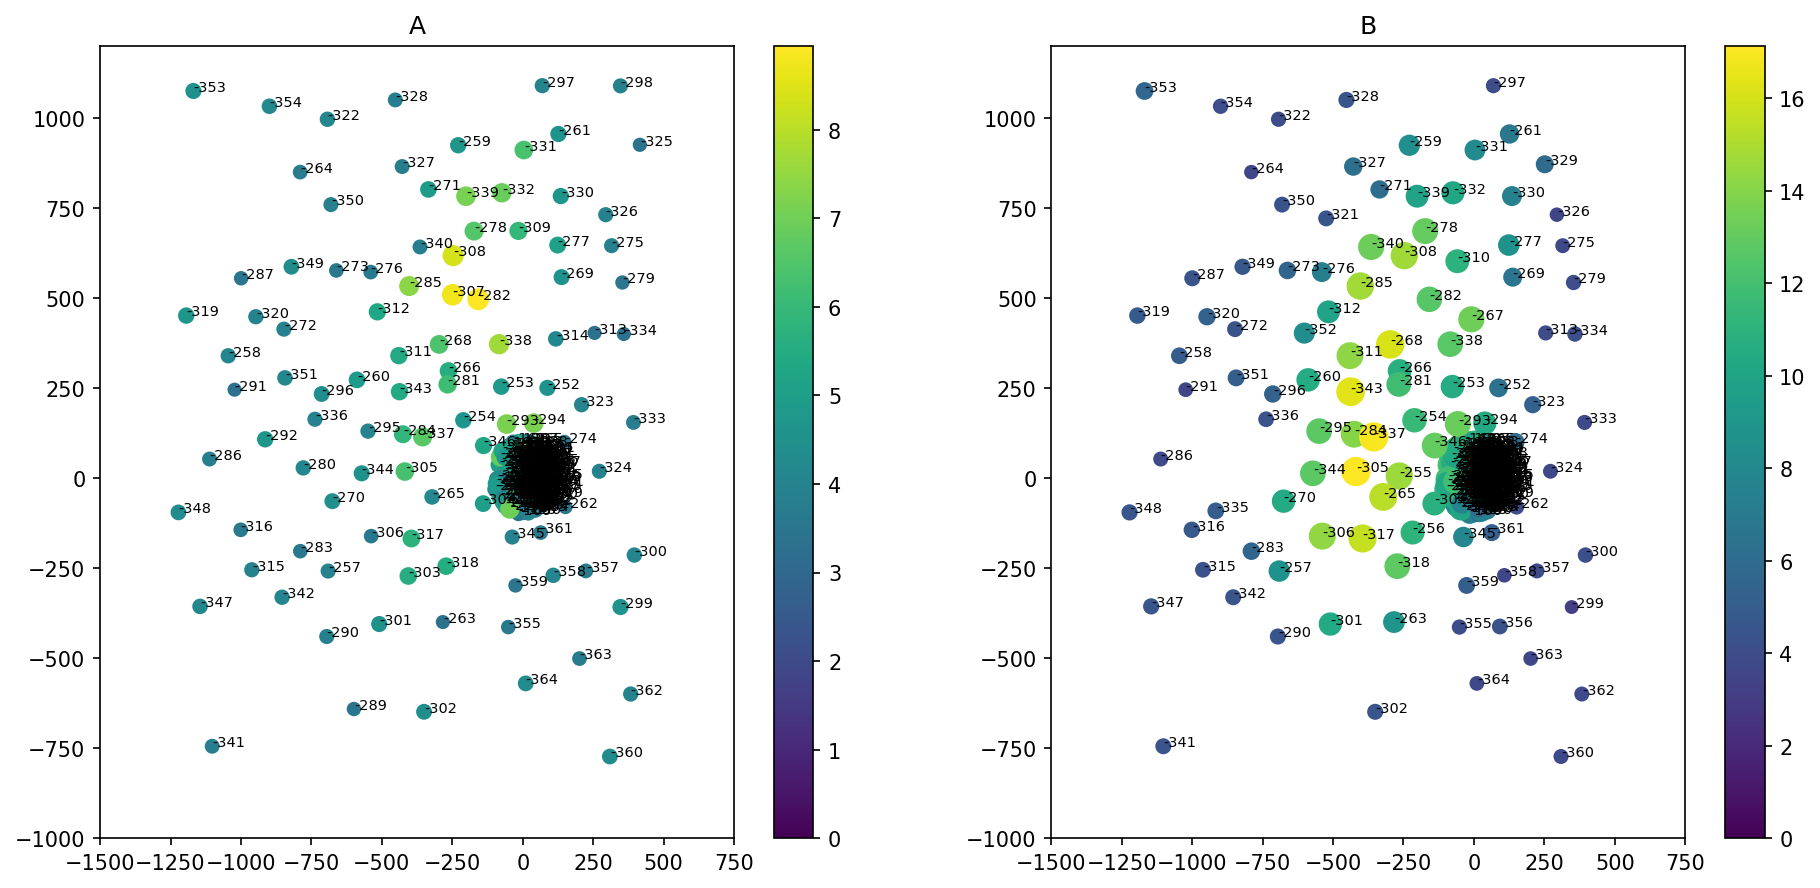

In [18]:
datafile='/lustre/kplant/2024February21/overnight1708578552.9377766.dat'
index_in_file=308374
config='/lustre/kplant/2024February21-dataproducts/config_preliminary_cuts.yml'

with open(config, 'r') as file:
    configuration=yaml.safe_load(file)
#array_map_filename=configuration['array_map_filename'] 
array_map_filename='/home/kplant/lwa-cosmic-rays/array-map-5-22-2023.csv'

lwa_df = reading.read_antpos()
namedict=build_mapping_dictionary(lwa_df)

array_map=pd.read_csv(array_map_filename)
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

fs= 196 #MHz


event_records=parsefile(datafile,start_ind=index_in_file,end_ind=704 )
event_summary=summarize_signals(event_records,np.asarray(configuration['filter']),namedict,xdict,ydict,zdict)

event_summary_flagged=flag_antennas(event_summary,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                    configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],1,
['LWA-288A', 'LWA-288B', 'LWA-147A', 'LWA-147B'])[0]

plt.figure(figsize=(15,7),dpi=150)
plt.subplot(121)
plt.title('A')
event_scatter_plot(event_summary_flagged,'snr',-105,105,-105,105,'A',annotate=True,markerscale=10,scale='linear',colorlimits='auto')
plt.subplot(122)
plt.title('B')
event_scatter_plot(event_summary_flagged,'snr',-105,105,-105,105,'B',annotate=True,markerscale=10,scale='linear',colorlimits='auto')

plt.figure(figsize=(15,7),dpi=150)
plt.subplot(121)
plt.title('A')
event_scatter_plot(event_summary_flagged,'snr',-1500,750,-1000,1200,'A',annotate=True,markerscale=10,scale='linear',colorlimits='auto')
plt.subplot(122)
plt.title('B')
event_scatter_plot(event_summary_flagged,'snr',-1500,750,-1000,1200,'B',annotate=True,markerscale=10,scale='linear',colorlimits='auto')
 

Reference antenna LWA-177
iteration:  0  rms residual:  21.188916940601626  n outliers:  35
popt:  [  66.23219011  194.36131049 4624.68811282]
pcov:  [[ 2.99781421e+00  1.62497664e-01  4.75759149e+02]
 [ 1.62497664e-01  7.55811325e+00 -9.42903272e+03]
 [ 4.75759149e+02 -9.42903272e+03  1.30390630e+07]]


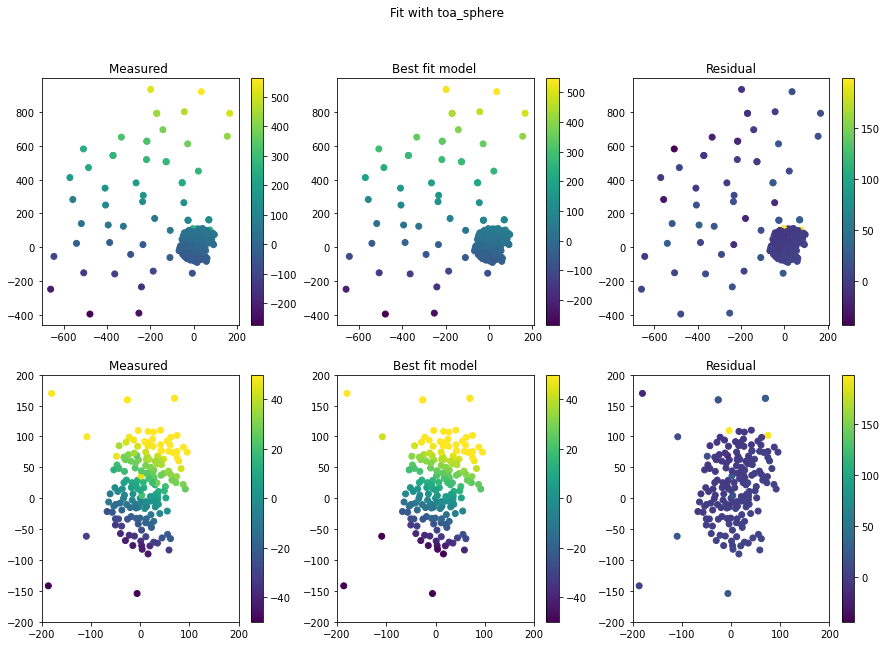

In [19]:
popt,pcov=robust_direction_fit(event_summary_flagged[event_summary_flagged['snr']>7],niter=3,outlier_limit=4,plot=True,toa_func=toa_sphere,fitbounds=([0,0,1],[90,360,1e5]))

In [20]:
phi_best=popt[1]

## Gaussian

In [21]:
def gauss2d(ant_coords,A,phi,w,r,xo,yo):
    #calculate the value of a 2D gaussian function at x,y positions listed in ant_coords
    #A is the amplitude of the Gaussian
    #phi is the azimuthal angle of the semimajor axis
    #sigx and sigy control the size scale in each direction
    #xo, yo are the center positions
    #phi in degrees
    #w, xo, and yo must all be in same units as ant_coords
    #r is related to the aspect ratio. Require r>=1 so that phi will be the angle between the semimajor axis and the north-south axis
    sigx=w
    sigy=r*w
    
    phi_rad=phi*math.pi/180
    sinphi=math.sin(phi_rad)
    cosphi=math.cos(phi_rad)

    a=(1/2)*(((cosphi/sigx)**2)+((sinphi/sigy)**2))
    b=(-1/2)*(sinphi*cosphi/(sigx**2))+(1/2)*(sinphi*cosphi/(sigy**2))
    c=(1/2)*(((sinphi/sigx)**2)+((cosphi/sigy)**2))
    x,y=ant_coords
    ellipse=(a*((x-xo)**2))+(2*b*((y-yo)*(x-xo)))+(c*(y-yo)**2)
    return A*np.exp(-1*ellipse)
    



(-1000.0, 1250.0)

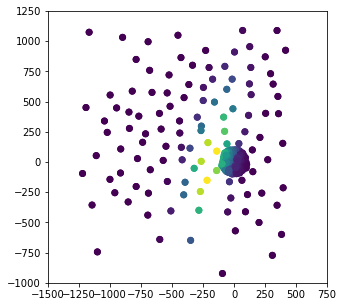

In [22]:
## test the 2D gaussian code
ant_coords=np.zeros((2,len(event_summary)))
ant_coords[0,:]=event_summary['x']
ant_coords[1,:]=event_summary['y']

gauss=gauss2d(ant_coords,A=1,phi=phi_best,w=100,r=4,xo=-200,yo=0)

plt.figure(figsize=(5,5))
plt.scatter(ant_coords[0,:],ant_coords[1,:],c=gauss)
plt.xlim(-1500,750)
plt.ylim(-1000,1250)

In [23]:
antenna_summary_array=event_summary_flagged[np.logical_and(event_summary_flagged['snr']>7,event_summary_flagged['pol']=='B')]


ant_coords=np.zeros((2,len(antenna_summary_array)))
ant_coords[0,:]=antenna_summary_array['x']
ant_coords[1,:]=antenna_summary_array['y']

snr=antenna_summary_array['snr']

poptg, pcovg = curve_fit(gauss2d, ant_coords,snr)
best_model_snrs=gauss2d(ant_coords,*poptg)
residual=snr-best_model_snrs

(-1000.0, 1250.0)

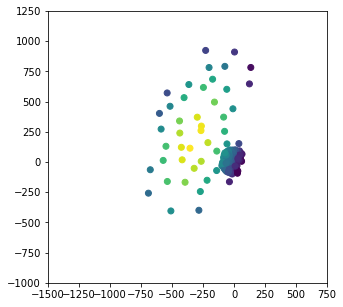

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(ant_coords[0,:],ant_coords[1,:],c=best_model_snrs)
plt.xlim(-1500,750)
plt.ylim(-1000,1250)

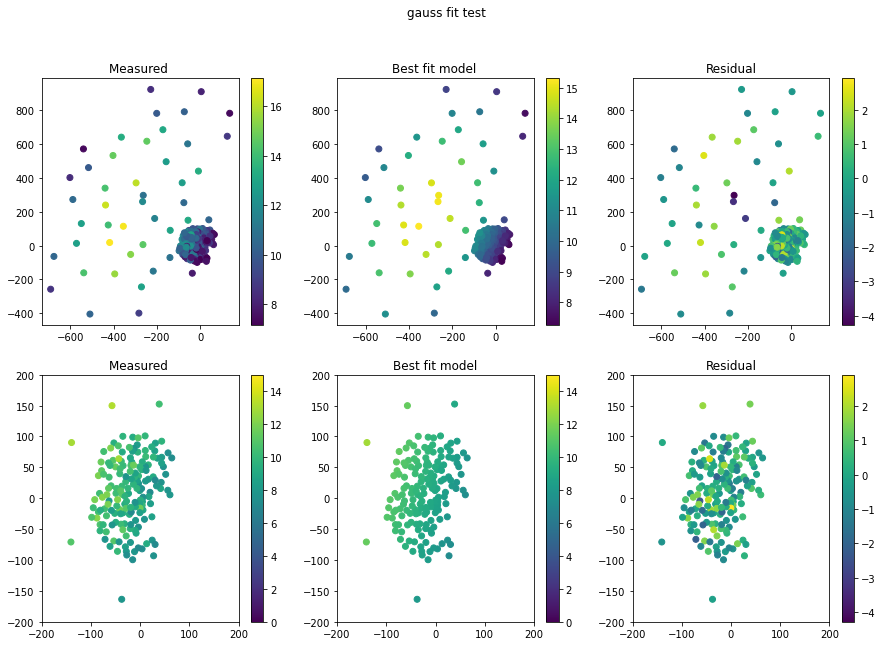

In [25]:
plot_fit(ant_coords[0,:],ant_coords[1,:],snr,best_model_snrs,residual,0,15,'gauss fit test')


In [26]:
phi_gauss=poptg[1]
print(phi_best,phi_gauss,180+phi_gauss)

194.36131048621994 17.7065787204046 197.7065787204046


### without separating polarizations
It looks like using a single polarization as was done above is better.

In [27]:
antenna_summary_array=event_summary_flagged[event_summary_flagged['snr']>7]


ant_coords=np.zeros((2,len(antenna_summary_array)))
ant_coords[0,:]=antenna_summary_array['x']
ant_coords[1,:]=antenna_summary_array['y']

snr=antenna_summary_array['snr']

poptg, pcovg = curve_fit(gauss2d, ant_coords,snr)
best_model_snrs=gauss2d(ant_coords,*poptg)
residual=snr-best_model_snrs

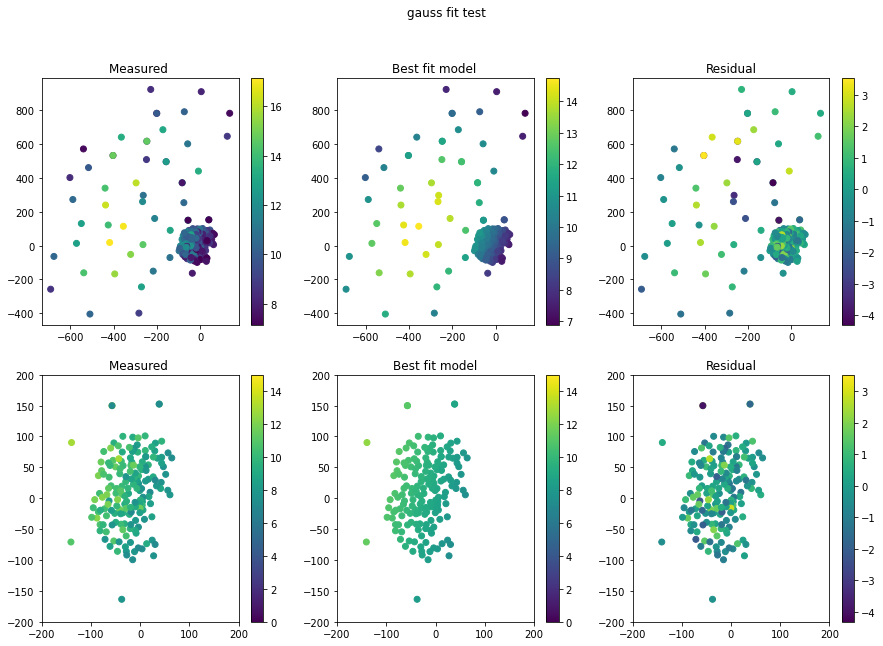

In [28]:
plot_fit(ant_coords[0,:],ant_coords[1,:],snr,best_model_snrs,residual,0,15,'gauss fit test')


### Robust fit

In [35]:
def robust_spatial_fit(antenna_summary_array,niter,outlier_limit,spatial_func,fitbounds,plot=True):
    current_ant_summary_array=antenna_summary_array
    for n in range(niter):
        #parse coordinates and snrs from summary array
        ant_coords=np.zeros((2,len(current_ant_summary_array)))
        ant_coords[0,:]=current_ant_summary_array['x']
        ant_coords[1,:]=current_ant_summary_array['y']
        snr=current_ant_summary_array['snr']
        
        #do fit
        poptg, pcovg = curve_fit(spatial_func, ant_coords,snr,bounds=fitbounds)
        
        #calculate residual
        best_model_snrs=gauss2d(ant_coords,*poptg)
        residual=snr-best_model_snrs
        rms_residual=np.sqrt(np.mean(np.square(residual)))
        #calculate outliers
        antpols=np.asarray([current_ant_summary_array['antname'][i]+current_ant_summary_array['pol'][i] for i in range(len(residual))])
        residual_med=np.median(residual)
        abs_dev_from_med=np.abs(residual-residual_med)
        residual_MAD=np.median(abs_dev_from_med)
        outliers=antpols[abs_dev_from_med>outlier_limit*residual_MAD]
        
        #remove outliers beyond threshold
        current_ant_summary_array=flag_antennas(current_ant_summary_array,configuration['maximum_ok_power'], configuration['minimum_ok_power'],
                                    configuration['minimum_ok_kurtosis'],configuration['maximum_ok_kurtosis'],10,outliers)[0]
        #plot  and report details if if that option is chosen
        if plot==True:
            #print details
            print('iteration: ',n,' rms residual: ',rms_residual, ' n outliers: ',len(outliers))
            print('popt: ',popt)
            print('pcov: ',pcov)
            plot_fit(ant_coords[0,:],ant_coords[1,:],snr,best_model_snrs,residual,np.min(snr),np.max(snr),'Fit with model function: '+'Fit with '+str(spatial_func)[10:-19])
    return popt,pcov

iteration:  0  rms residual:  1.3208213004982055  n outliers:  9
popt:  [  66.23219011  194.36131049 4624.68811282]
pcov:  [[ 2.99781421e+00  1.62497664e-01  4.75759149e+02]
 [ 1.62497664e-01  7.55811325e+00 -9.42903272e+03]
 [ 4.75759149e+02 -9.42903272e+03  1.30390630e+07]]
iteration:  1  rms residual:  1.076392940258054  n outliers:  4
popt:  [  66.23219011  194.36131049 4624.68811282]
pcov:  [[ 2.99781421e+00  1.62497664e-01  4.75759149e+02]
 [ 1.62497664e-01  7.55811325e+00 -9.42903272e+03]
 [ 4.75759149e+02 -9.42903272e+03  1.30390630e+07]]
iteration:  2  rms residual:  0.977087640221295  n outliers:  0
popt:  [  66.23219011  194.36131049 4624.68811282]
pcov:  [[ 2.99781421e+00  1.62497664e-01  4.75759149e+02]
 [ 1.62497664e-01  7.55811325e+00 -9.42903272e+03]
 [ 4.75759149e+02 -9.42903272e+03  1.30390630e+07]]


(array([  66.23219011,  194.36131049, 4624.68811282]),
 array([[ 2.99781421e+00,  1.62497664e-01,  4.75759149e+02],
        [ 1.62497664e-01,  7.55811325e+00, -9.42903272e+03],
        [ 4.75759149e+02, -9.42903272e+03,  1.30390630e+07]]))

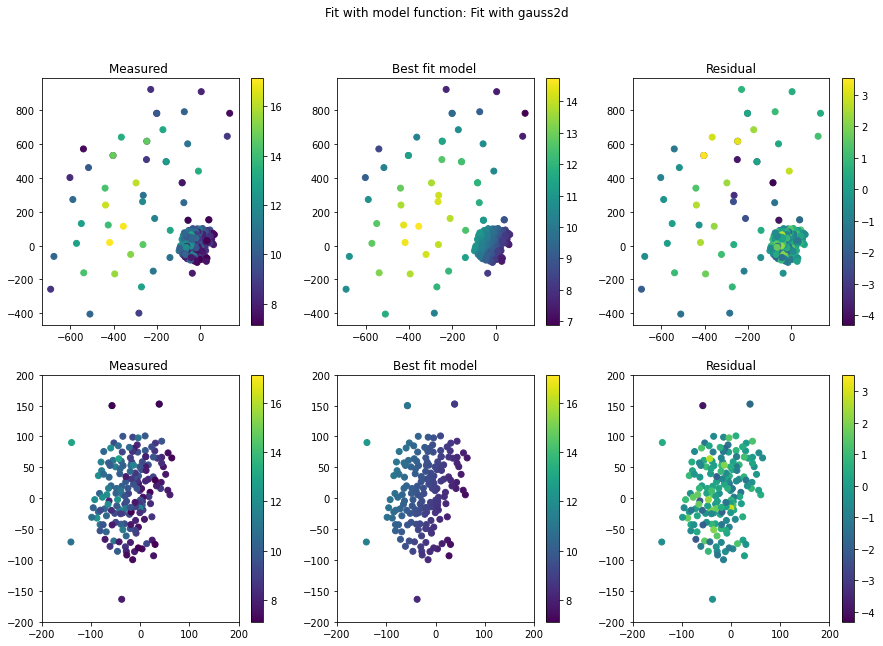

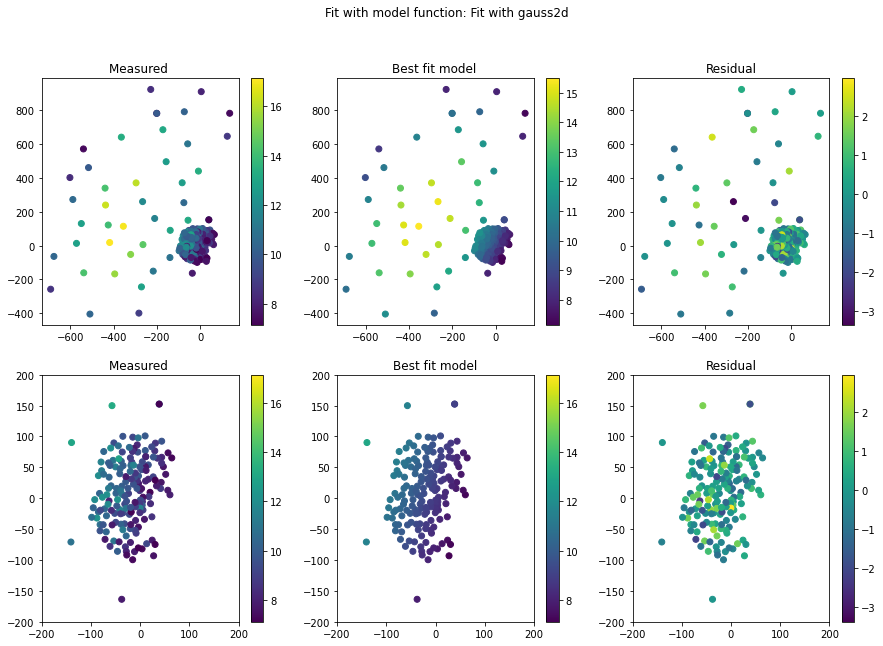

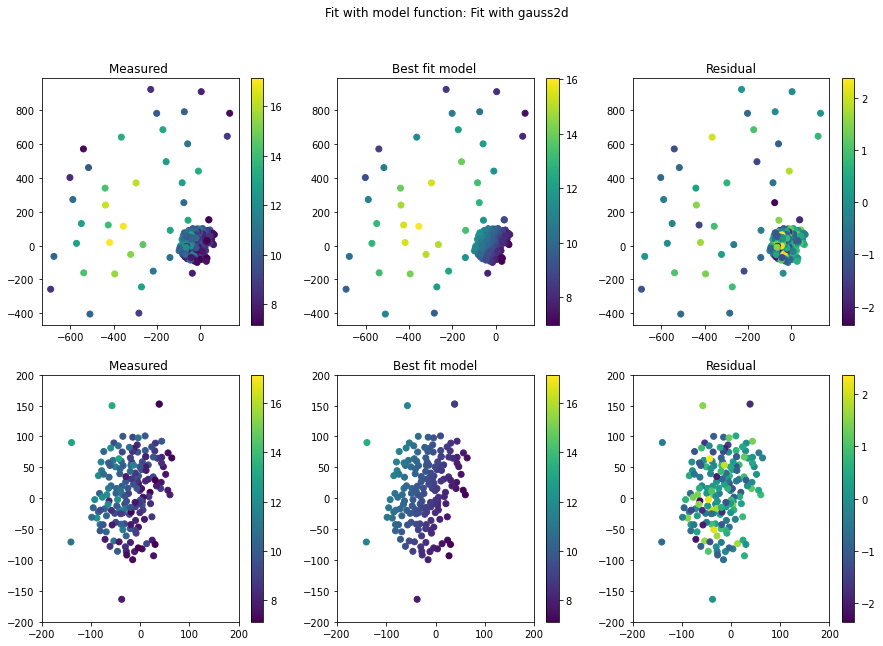

In [38]:
robust_spatial_fit(event_summary_flagged[event_summary_flagged['snr']>7],3,4,gauss2d,([0,0,0,1,-10000,-10000],[50,180,1000,100,10000,10000]))